# Staging Ground for Training Models


## Results 

### Navitoclax + 6 other apoptosis reg drugs

- This was with # features in selector = 1000 and with stratify on Y.mean cut -1, 1
- Best model is definitely SVM
- Other decent models are enet and etr
- Multi task models perform slightly worse on average
- Any imputation is better than Mean, though KNN or NNorm seem best
- Robust scaling is DEFINITELY not good
- Stratified CV seems to help slightly

### Navitoclax + 9 other most correlated drugs

- This was with # features in selector = 500 and with stratify on Y.min cut -1, 1

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_aggregation import entity
from mgds.data_modeling import data_broker as dbm
from mgds.data_modeling import training01 as rx_train
from mgds.data_modeling import data as feature_data

2017-02-20 06:00:50,600:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [2]:
datasets = api.get_genomic_data_availability()
d = db.cache_prep_operation(lambda: feature_data.get_feature_datasets(datasets), 'raw-features', overwrite=False)

2017-02-18 07:23:23,229:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"


# TPOT Tests

In [5]:
X = d[(src.CCLE_v1, dtyp.GENE_EXPRESSION)]
Y = d[(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)]['NAVITOCLAX']
mask = (X.notnull().any(axis=1)) & (Y.notnull())
X = X[mask]
Y = Y[mask]
X.shape, Y.shape

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


((541, 16042), (541,))

In [6]:
from tpot import TPOTRegressor

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    train_size=0.75, test_size=0.25)

est = Pipeline([
    ('nzv', VarianceThreshold()),
    ('select', SelectKBest(f_regression, k=1000)),
    ('est', TPOTRegressor(generations=5, population_size=20, verbosity=2, max_time_mins=30))
])

est.fit(X_train, y_train)
#print(est.score(X_test, y_test))
#tpot.export('tpot_boston_pipeline.py')

2017-01-29 10:35:31,362:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTP connection (1): updatechecker.bryceboe.com
2017-01-29 10:35:32,027:DEBUG:requests.packages.urllib3.connectionpool: http://updatechecker.bryceboe.com:80 "PUT /check HTTP/1.1" 200 106
Optimization Progress: 100%|██████████| 20/20 [12:52<00:00, 24.20s/pipeline]          

Generation 1 - Current best internal CV score: 1.985001385685587


Optimization Progress:  90%|█████████ | 36/40 [19:38<02:15, 33.78s/pipeline]Optimization Progress:  60%|██████    | 24/40 [13:56<06:13, 23.31s/pipeline]          

Generation 2 - Current best internal CV score: 1.985001385685587


Optimization Progress:  79%|███████▉  | 63/80 [21:41<05:26, 19.21s/pipeline]Optimization Progress:  75%|███████▌  | 45/60 [19:39<04:09, 16.64s/pipeline]Optimization Progress:  92%|█████████▏| 55/60 [19:51<00:20,  4.04s/pipeline]          

Generation 3 - Current best internal CV score: 1.9738314723395334


Optimization Progress:  99%|█████████▉| 79/80 [21:42<00:03,  3.28s/pipeline]Optimization Progress:  86%|████████▋ | 69/80 [21:42<01:43,  9.44s/pipeline]          Optimization Progress:  81%|████████  | 81/100 [21:42<00:43,  2.30s/pipeline]

Generation 4 - Current best internal CV score: 1.9610003013671082


Optimization Progress:  86%|████████▌ | 103/120 [24:02<01:22,  4.86s/pipeline]ptimization Progress:  86%|████████▌ | 86/100 [21:45<00:19,  1.39s/pipeline]          Optimization Progress: 100%|██████████| 100/100 [24:02<00:00,  6.92s/pipeline]

Generation 5 - Current best internal CV score: 1.9610003013671082


Optimization Progress:  99%|█████████▉| 119/120 [28:00<00:11, 12.00s/pipeline]                    

Generation 6 - Current best internal CV score: 1.9479549309893913


                                                                              Optimization Progress:  89%|████████▊ | 124/140 [28:04<01:39,  6.23s/pipeline]Optimization Progress:  93%|█████████▎| 130/140 [28:21<00:30,  3.08s/pipeline]


GP closed prematurely - will use current best pipeline

Best pipeline: ElasticNet(input_matrix, 0.12, 0.70000000000000007)


Pipeline(steps=[('nzv', VarianceThreshold(threshold=0.0)), ('select', SelectKBest(k=1000, score_func=<function f_regression at 0x110e23ae8>)), ('est', TPOTRegressor(crossover_rate=0.05, disable_update_check=False,
       generations=1000000, max_eval_time_mins=5, max_time_mins=30,
       mutation_rate=0.9, num_cv_folds=3, population_size=20,
       random_state=None, scoring=None, verbosity=2))])

In [9]:
tp = est.named_steps['est']

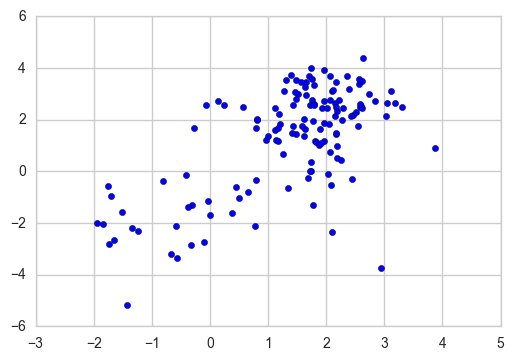

In [14]:
plt.scatter( est.predict(X_test), y_test)

In [22]:
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

params = {
    'C': [.001, .01, .1, 1, 10, 100]
}

# est2 = Pipeline([
#     ('nzv', VarianceThreshold()),
#     ('select', SelectKBest(f_regression, k=1000)),
#     ('est', ElasticNetCV(l1_ratio=.7))
# ])
est2 = Pipeline([
    ('nzv', VarianceThreshold()),
    ('scale', StandardScaler()),
    ('est', GridSearchCV(SVR(), params, cv=5, verbose=11))
])

est2.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.001 .........................................................
[CV] ............................... C=0.001, score=-0.061215 -   1.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ............................... C=0.001, score=-0.029377 -   1.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] ................................ C=0.001, score=0.000979 -   1.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[CV] ............................... C=0.001, score=-0.013899 -   1.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s


[CV] ............................... C=0.001, score=-0.189350 -   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s


[CV] ................................ C=0.01, score=-0.042775 -   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.8s remaining:    0.0s


[CV] ................................ C=0.01, score=-0.013830 -   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.8s remaining:    0.0s


[CV] ................................. C=0.01, score=0.012060 -   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.8s remaining:    0.0s


[CV] ................................ C=0.01, score=-0.000707 -   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.8s remaining:    0.0s


[CV] ................................ C=0.01, score=-0.168652 -   2.0s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.8s remaining:    0.0s


[CV] .................................. C=0.1, score=0.068864 -   2.0s
[CV] C=0.1 ...........................................................
[CV] .................................. C=0.1, score=0.090128 -   2.0s
[CV] C=0.1 ...........................................................
[CV] .................................. C=0.1, score=0.081967 -   2.0s
[CV] C=0.1 ...........................................................
[CV] .................................. C=0.1, score=0.103287 -   2.0s
[CV] C=0.1 ...........................................................
[CV] ................................. C=0.1, score=-0.022187 -   2.0s
[CV] C=1 .............................................................
[CV] .................................... C=1, score=0.381552 -   2.0s
[CV] C=1 .............................................................
[CV] .................................... C=1, score=0.330171 -   2.0s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.0min finished


Pipeline(steps=[('nzv', VarianceThreshold(threshold=0.0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('est', GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=Tr...01, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=11))])

In [26]:
x = est2.named_steps['est']
x.best_params_

{'C': 10}

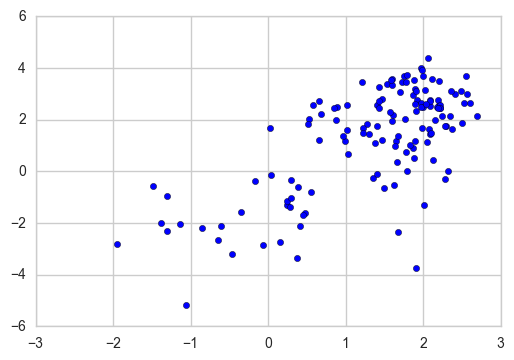

In [23]:
plt.scatter(est2.predict(X_test), y_test)

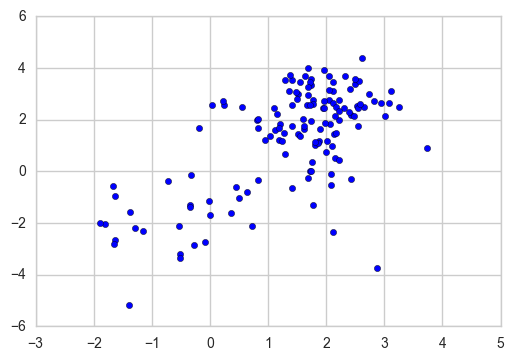

In [17]:
plt.scatter(est2.predict(X_test), y_test)

# Basic Models

In [3]:
# Apoptosis regulation drugs
# target_drugs = ['TW37','RTRAIL','EMBELIN','PAC1','OBATOCLAX','YM155','NAVITOCLAX']

# Navitoclax and 9 other most correlated drugs
# target_drugs = [
#     'NAVITOCLAX', 'VORINOSTAT', 'VX702', 'NILOTINIB', 
#     'GSK1070916', 'GDC0449', 'NPK76II721', 'BX912',
#     'AICAR', 'TUBASTATINA'
# ]

target_drugs = [
    'NAVITOCLAX', 'VORINOSTAT', 'NILOTINIB'
]

In [4]:
api.get_genomic_data_availability()

[('ccle_v1', 'gene-copy-number'),
 ('ccle_v1', 'gene-expression'),
 ('ccle_v1', 'gene-exome-seq'),
 ('gdsc_v2', 'gene-copy-number'),
 ('gdsc_v2', 'gene-expression'),
 ('gdsc_v2', 'gene-exome-seq'),
 ('nci60_v2', 'gene-copy-number'),
 ('nci60_v2', 'gene-expression'),
 ('nci60_v2', 'gene-exome-seq'),
 ('ncidream_v1', 'gene-copy-number'),
 ('ncidream_v1', 'gene-expression'),
 ('ncidream_v1', 'gene-exome-seq'),
 ('ncidream_v1', 'gene-methylation'),
 ('ncidream_v1', 'gene-rna-seq'),
 ('gdsc_v2', 'drug-sensitivity'),
 ('ctd_v2', 'drug-sensitivity'),
 ('nci60_v2', 'drug-sensitivity'),
 ('ncidream_v1', 'drug-sensitivity')]

In [29]:
datasets = api.get_genomic_data_availability()
dt = feature_data.get_feature_datasets([(src.TCGA_v1, dtyp.GENE_RPPA)])
dt.info()

2017-02-18 08:11:54,674:INFO:mgds.data_modeling.data: Unpacking source "tcga_v1", data set "gene-rppa"


TypeError: 'NoneType' object does not support item assignment

In [78]:
X = d[(src.GDSC_v2, dtyp.GENE_EXPRESSION)]
#X = d[(src.GDSC_v2, dtyp.GENE_METHYLATION)]

Y = d[[c for c in d if c[1] == dtyp.DRUG_SENSITIVITY and c[2] in target_drugs]]
#Y = d[[c for c in d if c[1] == dtyp.GENE_RPPA]]
Y.columns = ['{}:{}'.format(c[0], c[2]) for c in Y]

#Y = d[(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)][target_drugs]

mask = (X.isnull().mean(axis=1) < .1) & (Y.notnull().any(axis=1))
#mask = (X.notnull().any(axis=1)) & (Y.notnull().any(axis=1))
X = X[mask]
Y = Y[mask]

X = X.sort_index()
Y = Y.sort_index()

# X should not have nulls now, or logic needs to be added to deal with that
assert X.notnull().all().all()
assert X.shape[0] == Y.shape[0]
X.shape, Y.shape

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning:

indexing past lexsort depth may impact performance.



((943, 17419), (943, 8))

In [85]:
mask = X.index.get_level_values('PRIMARY_SITE:MGDS') == 'BREAST'
Y[mask]['gdsc_v2:NAVITOCLAX'].sort_index().dropna()

CELL_LINE_ID:MGDS  PRIMARY_SITE:MGDS
AU565              BREAST               1.981488
BT20               BREAST               1.097944
BT474              BREAST               3.385941
BT483              BREAST               2.812405
BT549              BREAST               4.005554
CAL120             BREAST               0.229960
CAL51              BREAST               2.786963
CAL851             BREAST               3.246008
COLO824            BREAST               0.067460
DU4475             BREAST              -0.358201
EFM192A            BREAST               1.003210
EVSAT              BREAST               1.501455
HCC1143            BREAST               2.802647
HCC1187            BREAST               2.523995
HCC1395            BREAST               1.626645
HCC1419            BREAST               0.876359
HCC1428            BREAST               1.748952
HCC1500            BREAST              -2.982803
HCC1569            BREAST              -1.447012
HCC1806            BREAST       

In [25]:
Y.head()

gdsc_v2:NAVITOCLAX  gdsc_v2:NILOTINIB  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
AU565             BREAST                       1.981488           3.199612   
BT20              BREAST                       1.097944           3.658667   
BT474             BREAST                       3.385941           3.699121   
BT483             BREAST                       2.812405           5.146388   
BT549             BREAST                       4.005554           3.693210   

                                     gdsc_v2:VORINOSTAT  ctd_v2:NAVITOCLAX  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
AU565             BREAST                       1.055134             14.109   
BT20              BREAST                       1.924730             13.753   
BT474             BREAST                       1.531145             15.937   
BT483             BREAST                       2.872684                NaN   
BT549             BREAST                       1.749984             13.600   

                                     ctd_v2:NILOTINIB  ctd_v2:VORINOSTAT  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
AU565             BREAST                       12.677             11.067   
BT20              BREAST                       12.708             13.320   
BT474             BREAST                       15.615             11.819   
BT483             BREAST                          NaN                NaN   
BT549             BREAST                       20.000             13.623   

                                     nci60_v2:NILOTINIB  nci60_v2:VORINOSTAT  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST                            NaN                  NaN  
BT20              BREAST                            NaN                  NaN  
BT474             BREAST                            NaN                  NaN  
BT483             BREAST                            NaN                  NaN  
BT549             BREAST                     -12.537576           -13.285916

In [7]:
d[(src.NCI60_v2, dtyp.DRUG_SENSITIVITY)].filter(items=target_drugs).notnull().sum()

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning:

indexing past lexsort depth may impact performance.



VORINOSTAT    59
NILOTINIB     59
dtype: int64

In [8]:
for drug in target_drugs:
    print(drug, '\n', Y.filter(regex=drug).notnull().sum(axis=1).value_counts(), '\n\n')

NAVITOCLAX 
 1    463
2    459
0     21
dtype: int64 


VORINOSTAT 
 1    448
2    437
3     33
0     25
dtype: int64 


NILOTINIB 
 1    442
2    421
0     50
3     30
dtype: int64 




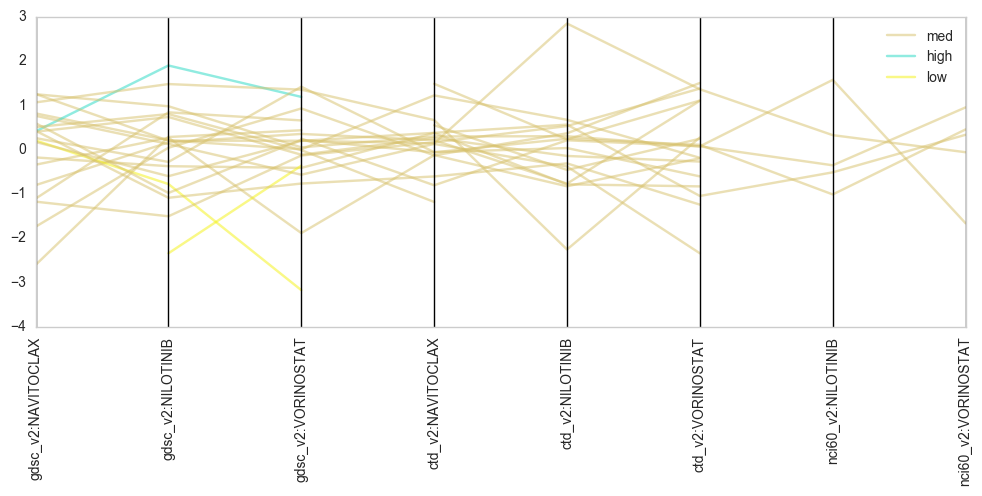

In [26]:
from pandas.tools.plotting import parallel_coordinates
dY = Y.copy().apply(lambda v: (v-v.mean())/v.std())
dY['class'] = pd.cut(dY.mean(axis=1), [-np.inf, -1, 1, np.inf], labels=['low', 'med', 'high'])
plt.figure(figsize=(12,4))
ax = parallel_coordinates(dY, 'class', alpha=.5)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
print()

In [10]:
dY['class'].value_counts()

med     827
low      74
high     42
Name: class, dtype: int64

In [431]:
d.iloc[:, :10].columns.sort_values().tolist()

[('ccle_v1', 'gene-copy-number', 'A1BG'),
 ('ccle_v1', 'gene-copy-number', 'A1BG-AS1'),
 ('ccle_v1', 'gene-copy-number', 'A1CF'),
 ('ccle_v1', 'gene-copy-number', 'A2M'),
 ('ccle_v1', 'gene-copy-number', 'A2ML1'),
 ('ccle_v1', 'gene-copy-number', 'A4GALT'),
 ('ccle_v1', 'gene-copy-number', 'A4GNT'),
 ('ccle_v1', 'gene-copy-number', 'AAAS'),
 ('ccle_v1', 'gene-copy-number', 'AACS'),
 ('ccle_v1', 'gene-copy-number', 'AACSP1')]

In [11]:
from ml.api import trainer as ml_trainer

from ml.sklearn import feature_selection as ml_feature_selection
from ml.sklearn import transform as ml_transform
from ml.sklearn import multioutput as ml_multioutput

from mgds.data_modeling.constants import SEED
from sklearn.linear_model import ElasticNet, MultiTaskElasticNet, LassoLarsCV, LassoLarsIC, RandomizedLasso
from sklearn.linear_model import MultiTaskLassoCV, LassoCV 
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline

from fancyimpute import MICE, NuclearNormMinimization, KNN, BiScaler

Using TensorFlow backend.


In [315]:
import imp
imp.reload(ml_transform)
imp.reload(ml_feature_selection)
imp.reload(ml_multioutput)

<module 'ml.sklearn.multioutput' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/sklearn/multioutput.py'>

In [12]:
from scipy.sparse import csr_matrix

def get_modeling_results(X, Y, clfs, cv_fn, refit=False):
    
    cv = cv_fn(X, Y)
    
#     def data_prep_fn(X_train, X_test, Y_train, Y_test):
#         imp = response_imputer_fn()
#         Y_train = pd.DataFrame(imp.transform(Y_train), columns=Y_train.columns, index=Y_train.index)
#         return X_train, X_test, Y_train, Y_test

    def model_fit_fn(clf_name, clf, X_train, Y_train, X_test, Y_test, fold):
        clf.fit(X_train.values, Y_train.values)

    config = ml_trainer.TrainerConfig(
        #data_prep_fn=data_prep_fn,
        model_fit_fn=model_fit_fn,
        keep_test_data=True,
        refit=refit
    )

    trainer = ml_trainer.Trainer()
    return trainer.train_regressors(X, Y, clfs, cv, config=config)

def save_modeling_results(train_res, experiment_num, experiment_name):
    description = rx_train.get_result_description(experiment_name)
    return rx_train.save_training_results(train_res, 'single_source/current', experiment_num, description)

imputer_mean = lambda X: Imputer(strategy='mean').fit_transform(X)
imputer_mice = lambda X: MICE(verbose=False).complete(np.array(X))
imputer_knn = lambda X: KNN(verbose=False, normalizer=BiScaler(verbose=False, center_rows=False, scale_rows=False)).complete(np.array(X))
imputer_nnorm = lambda X: NuclearNormMinimization(verbose=False).complete(np.array(X))

def X_imputer(imputer_fn):
    def transform(X):
        if np.any(np.isnan(X)):
            X = imputer_fn(X)
        return X
    return FunctionTransformer(transform, validate=False)

def Y_imputer(imputer_fn):
    def transform(X, Y):
        if np.any(np.isnan(Y)):
            Y = imputer_fn(Y)
        return X, Y
    return transform

def Y_dropper(X, y):
    assert y.ndim == 1
    mask = ~np.isnan(y)
    X, y = X[mask], y[mask]
    return X, y

def get_pipelines(estimators, use_selector=False, use_robust_scaler=False, 
                  use_nzv_filter=True, st_res_imputer=None, mt_res_imputer=imputer_mean):
    clfs = {}
    for name in estimators:
        steps = []
        
        if use_nzv_filter:
            steps.append(('nzv', VarianceThreshold()))
            
        if use_robust_scaler:
            steps.append(('scale', RobustScaler()))
        else:
            steps.append(('scale', StandardScaler()))
            
        if use_selector:
            # steps.append(('select', ml_feature_selection.MultiOutputSelect(selector=SelectKBest(f_regression, k=1000), strategy='any')))
            selector = SelectKBest(f_regression, k=500)
            selector = ml_transform.TransformEstimator(estimator=selector, transformer=Y_dropper)
            steps.append(('select', ml_feature_selection.MultiOutputSelect(selector=selector, strategy='any')))

        # Add response transformation wrappers
        clf = estimators[name]
        if name.endswith('_st'):
            if st_res_imputer is None:
                clf = ml_transform.TransformEstimator(estimator=clf, transformer=Y_dropper)
                clf = ml_multioutput.MultiRegressor(clf)
            else:
                clf = ml_multioutput.MultiRegressor(clf)
                clf = ml_transform.TransformEstimator(estimator=clf, transformer=Y_imputer(st_res_imputer))
        elif name.endswith('_mt'):
            clf = ml_transform.TransformEstimator(estimator=clf, transformer=Y_imputer(mt_res_imputer))
        else:
            raise ValueError('Not sure how to handle estimator named "{}"'.format(name))
            
        steps.append(('clf', clf))
        clfs[name] = Pipeline(steps)
    return clfs

cv_random = lambda X, Y: KFold(n_splits=10, shuffle=True, random_state=SEED).split(X)
def cv_stratify(X, Y):
    y_class = pd.cut(Y.apply(lambda v: (v - v.mean()) / v.std()).mean(axis=1), [-np.inf, -1, 1, np.inf])
    assert np.all(y_class.notnull())
    return StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED).split(X, y_class)

In [13]:
pd.cut(Y.apply(lambda v: (v - v.mean()) / v.std()).mean(axis=1), [-np.inf, -1, 1, np.inf]).value_counts()

(-1, 1]       827
(-inf, -1]     74
(1, inf]       42
dtype: int64

In [261]:
#pd.cut(Y.mean(axis=1), [-np.inf, -1, 1, np.inf])

In [14]:
# Standard vs Robust scaling
# Feature selection vs no feature selection
# Stratified vs not
# Multitask vs not
# Impute MICE vs Mean Impute
# Add these 3 as an experiment: LassoLarsCV, LassoLarsIC, RandomizedLasso, Lasso
results = {}

base_clfs = {
    'larsic_st':LassoLarsIC(criterion='bic', normalize=True),
    'larscv_st': LassoLarsCV(normalize=True, cv=3, max_n_alphas=30),
    'lasso_mt': MultiTaskLassoCV(random_state=SEED, alphas=[.1, .5, 1, 5, 10, 25]),
    'lasso_st': LassoCV(random_state=SEED, alphas=[.1, .5, 1, 5, 10, 25]),
    'enet_st': ElasticNet(random_state=SEED, l1_ratio=.7, alpha=.1),
    'enet_mt': MultiTaskElasticNet(random_state=SEED, l1_ratio=.7, alpha=.1),
    #'knn_mt': KNeighborsRegressor(n_neighbors=10, weights='distance', p=2),
    #'rf_st': MultiOutputRegressor(RandomForestRegressor(random_state=SEED)),
    #'rf_mt': RandomForestRegressor(random_state=SEED),
    'etr_st': ExtraTreesRegressor(random_state=SEED),
    'etr_mt': ExtraTreesRegressor(random_state=SEED),
    'svr_st': GridSearchCV(SVR(), {'C': [.1, 1, 10, 50, 100]}, cv=3),
    'baseline_mt': DummyRegressor()
}

## Experiment 1

In [82]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True)
experiment_name = 'Scaler=Standard:Selector=FReg:Impute=Mean:CV=Random'
train_res = get_modeling_results(X, Y, clfs, response_imputer_mean, cv_random)

2017-02-15 14:57:54,243:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 10), dim(Y_test) = (64, 10)
2017-02-15 14:57:54,243:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 10), dim(Y_test) = (64, 10)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-02-15 14:57:55,245:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 10), dim(Y_test) = (64, 10)
2017-02-15 14:57:55,245:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 10), dim(Y_test) = (64, 10)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1739: UserWarning:

Objective did not converge, you might want to increase the number of iterations

2017-02-15 14:58:00,454:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 10), dim(Y_test) = (64, 10)
2017-02-15 14:58:00,454:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 10), dim(Y_test) = (64, 10)
2017-02-15 14:5

In [83]:
save_modeling_results(train_res, 'exp1', experiment_name)

2017-02-15 15:27:00,531:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp1/results.pkl"
2017-02-15 15:27:00,531:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp1/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp1'

## Experiment 2

In [139]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True, use_robust_scaler=True)
experiment_name = 'Scaler=Robust:Selector=FReg:Impute=Mean:CV=Random'
train_res = get_modeling_results(X, Y, clfs, response_imputer_mean, cv_random)

2017-01-29 13:43:52,171:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-01-29 13:43:53,255:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1739: UserWarning: Objective did not converge, you might want to increase the number of iterations
  warnings.warn('Objective did not converge, you might want'
2017-01-29 13:44:04,439:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
2017-01-29 13:44:12,535:INFO:ml.model.log: Running model etr (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
2017-01-29 13:44:18,498:INFO:ml.model.log: Running model rf (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572,

In [140]:
save_modeling_results(train_res, 'exp2', experiment_name)

2017-01-29 14:08:41,661:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp2/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp2'

# Experiment 3

- Run this overnight - without a selector its too slow

In [227]:
exp_clfs = {k:v for k, v in base_clfs.items()}
clfs = get_pipelines(exp_clfs, use_selector=False)
experiment_name = 'Scaler=Standard:Selector=None:Impute=MICE:CV=Stratify'
train_res = get_modeling_results(X, Y, clfs, response_imputer_mice, cv_stratify)

2017-01-29 20:22:12,071:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-01-29 20:22:12,342:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 20:22:25,199:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 20:22:30,395:INFO:ml.model.log: Running model etr_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 20:22:51,820:INFO:ml.model.log: Running model etr_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 20:25:06,366:INFO:ml.model.log: Running model knn_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 20:25:07,561:INFO:ml.model.

In [232]:
save_modeling_results(train_res, 'exp3', experiment_name)

2017-01-30 06:33:27,405:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp3/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp3'

# Experiment 4

In [116]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True)
experiment_name = 'Scaler=Standard:Selector=FReg:Impute=Mean:CV=Stratify'
train_res = get_modeling_results(X, Y, clfs, response_imputer_mean, cv_stratify)

2017-02-15 18:35:15,028:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 18:35:15,028:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-02-15 18:35:15,986:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 18:35:15,986:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1739: UserWarning:

Objective did not converge, you might want to increase the number of iterations

2017-02-15 18:35:21,086:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 18:35:21,086:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 18:3

In [117]:
save_modeling_results(train_res, 'exp4', experiment_name)

2017-02-15 19:04:24,858:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp4/results.pkl"
2017-02-15 19:04:24,858:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp4/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp4'

## Experiment 5

In [15]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True, st_res_imputer=None, mt_res_imputer=imputer_mice)
experiment_name = 'Scaler=Standard:Selector=FReg:Impute=MICE:CV=Stratify'
train_res = get_modeling_results(X, Y, clfs, cv_stratify)

2017-02-18 07:26:15,701:INFO:ml.model.log: Running model baseline_mt (Pipeline) on fold 1 ==> dim(X_train) = (847, 17419), dim(X_test) = (96, 17419), dim(Y_train) = (847, 8), dim(Y_test) = (96, 8)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-02-18 07:26:17,989:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (847, 17419), dim(X_test) = (96, 17419), dim(Y_train) = (847, 8), dim(Y_test) = (96, 8)
2017-02-18 07:26:26,637:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (847, 17419), dim(X_test) = (96, 17419), dim(Y_train) = (847, 8), dim(Y_test) = (96, 8)
2017-02-18 07:26:29,372:INFO:ml.model.log: Running model etr_mt (Pipeline) on fold 1 ==> dim(X_train) = (847, 17419), dim(X_test) = (96, 17419), dim(Y_train) = (847, 8), dim(Y_test) = (96, 8)
2017-02-18 07:26:34,980:INFO:ml.model.log: Running model etr_st (Pipeline) on fold 1 ==> dim(X_train) = (847, 17419), dim(X_test) = (96, 17419), dim(Y_train) = (847, 8), dim(Y_test) = (96, 8)
2017-02-18 07:26:49,063:INFO:ml.model.log: Running model larscv_st (Pipeline) on fold 1 ==> dim(X_train) = (847, 17419), dim(X_test) = (96, 17419), dim(Y_train) = (847, 8), dim(Y_test) = (96, 8)
2017-02-18 07:27:13,621:INFO:ml.mod

In [16]:
save_modeling_results(train_res, 'exp5b', experiment_name)

2017-02-18 07:57:11,235:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp5b/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp5b'

## Experiment 6

In [99]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True)
experiment_name = 'Scaler=Standard:Selector=FReg:Impute=KNN:CV=Stratify'
train_res = get_modeling_results(X, Y, clfs, response_imputer_knn, cv_stratify)

2017-02-15 16:05:10,700:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 16:05:10,700:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-02-15 16:05:11,758:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 16:05:11,758:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1739: UserWarning:

Objective did not converge, you might want to increase the number of iterations

2017-02-15 16:05:16,848:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 16:05:16,848:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 16:0

In [101]:
save_modeling_results(train_res, 'exp6', experiment_name)

2017-02-15 17:12:48,370:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp6/results.pkl"
2017-02-15 17:12:48,370:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp6/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp6'

## Experiment 7

In [106]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True)
experiment_name = 'Scaler=Standard:Selector=FReg:Impute=NNorm:CV=Stratify'
train_res = get_modeling_results(X, Y, clfs, response_imputer_nnorm, cv_stratify)

Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-02-15 17:16:26,027:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 17:16:26,027:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 17:16:27,022:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
2017-02-15 17:16:27,022:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 10), dim(Y_test) = (65, 10)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1739: UserWarning:

Objective did not converge, you might want to increase the number of iterations

2017-02-15 17

In [107]:
save_modeling_results(train_res, 'exp7', experiment_name)

2017-02-15 17:48:42,043:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp7/results.pkl"
2017-02-15 17:48:42,043:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp7/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp7'

In [13]:
# from py_utils import io_utils
# train_res = io_utils.from_pickle('/Users/eczech/data/research/mgds/modeling/rx/results/single_source/navitoclax_correlates/exp5b/results.pkl')

2017-02-20 06:06:35,565:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/navitoclax_correlates/exp5b/results.pkl"


# Results Analysis

In [5]:
from ml.api.results import predictions, performance, properties

In [14]:
d_pred = predictions.extract(train_res)

In [140]:
# for fold_res in train_res.resample_results:
#     for model_res in fold_res.model_results:
# #         if model_res.clf_name == 'lasso_st':
# #             est = model_res.clf.named_steps['clf']
# #             for m in est.estimators_:
# #                 print(m.alpha_)
#         if model_res.clf_name == 'svr_st':
#             est = model_res.clf.named_steps['clf']
#             for m in est.estimators_:
#                 print(m.best_params_)

In [15]:
d_pred['Predictions'].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8650 entries, (BCP1, HAEMATOPOIETIC_AND_LYMPHOID_TISSUE) to (WM88, SKIN)
Data columns (total 16 columns):
Value:Actual:ctd_v2:NAVITOCLAX         7580 non-null float64
Value:Actual:ctd_v2:NILOTINIB          7430 non-null float64
Value:Actual:ctd_v2:VORINOSTAT         7430 non-null float64
Value:Actual:gdsc_v2:NAVITOCLAX        5410 non-null float64
Value:Actual:gdsc_v2:NILOTINIB         5160 non-null float64
Value:Actual:gdsc_v2:VORINOSTAT        5420 non-null float64
Value:Actual:nci60_v2:NILOTINIB        370 non-null float64
Value:Actual:nci60_v2:VORINOSTAT       370 non-null float64
Value:Predicted:ctd_v2:NAVITOCLAX      8650 non-null float64
Value:Predicted:ctd_v2:NILOTINIB       8650 non-null float64
Value:Predicted:ctd_v2:VORINOSTAT      8650 non-null float64
Value:Predicted:gdsc_v2:NAVITOCLAX     8650 non-null float64
Value:Predicted:gdsc_v2:NILOTINIB      8650 non-null float64
Value:Predicted:gdsc_v2:VORINOSTAT     8650 non-null 

In [382]:
imp.reload(performance)

<module 'ml.api.results.performance' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/performance.py'>

In [51]:
# dt = d[d.index.get_level_values('PRIMARY_SITE:MGDS') == 'BREAST']
# dt[(src.GDSC_v2, dtyp.DRUG_SENSITIVITY, 'NAVITOCLAX')].dropna().sort_values()

In [16]:
from ml.api.results import performance
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, mean_absolute_error


score_fns = {
    'mse': lambda yt, yp: -mean_squared_error(yt, yp),
    'mae': lambda yt, yp: -mean_absolute_error(yt, yp),
    'mde': lambda yt, yp: -median_absolute_error(yt, yp),
    'n': lambda yt, yp: len(yt),
    'r2': lambda yt, yp: r2_score(yt, yp), 
    'pearson': lambda yt, yp: yt.corr(yp, method='pearson'),
    'spearman': lambda yt, yp: yt.corr(yp, method='spearman')
}
def score_fn(y_true, y_pred):
    mask = y_true.notnull()
    y_true = y_true[mask.values]
    y_pred = y_pred[mask.values]
    if len(y_pred) == 0:
        return {k:np.nan for k in score_fns}
    else:
        return {k:score_fns[k](y_true, y_pred) for k in score_fns}

#d_score = performance.extract(train_res, d_pred, score_fn)
d_score = performance.extract(
    train_res, d_pred[d_pred.index.get_level_values('PRIMARY_SITE:MGDS').isin(['BREAST'])], 
    score_fn
)

d_score_norm = d_score.apply(lambda v: (v - v.mean()) / v.std())
d_score_norm.head()

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning:

divide by zero encountered in double_scalars



Metric                         mae                                     \
Task             ctd_v2:NAVITOCLAX ctd_v2:NILOTINIB ctd_v2:VORINOSTAT   
Model       Fold                                                        
baseline_mt 1             0.033393         0.111875         -0.111677   
            2             0.512335         0.525894          0.721038   
            3             0.180469        -2.573972         -0.166712   
            4            -2.569078         0.727739          0.755728   
            5            -0.156574         0.084521          0.592060   

Metric                                                                    \
Task             gdsc_v2:NAVITOCLAX gdsc_v2:NILOTINIB gdsc_v2:VORINOSTAT   
Model       Fold                                                           
baseline_mt 1              0.159848         -1.130356          -0.243646   
            2             -0.468215         -0.475244          -0.339891   
            3             -1.976024         -2.044853          -0.661534   
            4              0.324083          0.461431           0.483555   
            5              0.055203          0.605398           0.780889   

Metric                                                                mde  \
Task             nci60_v2:NILOTINIB nci60_v2:VORINOSTAT ctd_v2:NAVITOCLAX   
Model       Fold                                                            
baseline_mt 1                   NaN                 NaN         -0.248075   
            2              0.596987           -1.995112          0.077882   
            3             -0.743567            0.316565          0.044238   
            4                   NaN                 NaN         -2.104289   
            5             -0.694860           -0.314886         -0.361577   

Metric                                    ...                         r2  \
Task             ctd_v2:NILOTINIB         ...         nci60_v2:NILOTINIB   
Model       Fold                          ...                              
baseline_mt 1            0.057122         ...                        NaN   
            2            0.466902         ...                   0.517014   
            3           -2.632651         ...                   0.517014   
            4            0.619217         ...                        NaN   
            5           -0.170054         ...                   0.049175   

Metric                                        spearman                   \
Task             nci60_v2:VORINOSTAT ctd_v2:NAVITOCLAX ctd_v2:NILOTINIB   
Model       Fold                                                          
baseline_mt 1                    NaN               NaN              NaN   
            2               0.343577               NaN              NaN   
            3               0.343577               NaN              NaN   
            4                    NaN               NaN              NaN   
            5              -1.463567               NaN              NaN   

Metric                                                                   \
Task             ctd_v2:VORINOSTAT gdsc_v2:NAVITOCLAX gdsc_v2:NILOTINIB   
Model       Fold                                                          
baseline_mt 1                  NaN                NaN               NaN   
            2                  NaN                NaN               NaN   
            3                  NaN                NaN               NaN   
            4                  NaN                NaN               NaN   
            5                  NaN                NaN               NaN   

Metric                                                                      
Task             gdsc_v2:VORINOSTAT nci60_v2:NILOTINIB nci60_v2:VORINOSTAT  
Model       Fold                                                            
baseline_mt 1                   NaN                NaN                 NaN  
            2                   NaN                NaN                

In [68]:
dt = d_pred[d_pred.index.get_level_values('PRIMARY_SITE:MGDS').isin(['BREAST'])]
dt = dt[dt['Metadata']['Model'] == 'etr_mt']['Predictions']['Value:Predicted:gdsc_v2:NAVITOCLAX']
len(dt)

48

In [17]:
#tasks = performance.sample_tasks(d_score, random_state=None, limit=10)
# d_score_norm
figs = performance.visualize(
    performance.melt(d_score), 
    #metrics=['pearson', 'spearman'],
    metrics=['pearson'],
    backend='plotly'
#     backend='seaborn',
#     figaspect=4, legend_margin=(1.14, 1)
)

In [387]:
#tasks = performance.sample_tasks(d_score, random_state=None, limit=10)
# d_score_norm
figs = performance.visualize(
    performance.melt(d_score), 
    #metrics=['pearson', 'spearman'],
    metrics=['pearson'],
    backend='plotly'
#     backend='seaborn',
#     figaspect=4, legend_margin=(1.14, 1)
)
print(experiment_name)

Scaler=Standard:Selector=FReg:Impute=MICE:CV=Stratify


In [113]:
#tasks = performance.sample_tasks(d_score, random_state=None, limit=10)
# d_score_norm
figs = performance.visualize(
    performance.melt(d_score_norm), 
    #metrics=['pearson', 'spearman'],
    metrics=['mse'],
    backend='plotly'
#     backend='seaborn',
#     figaspect=4, legend_margin=(1.14, 1)
)
print(experiment_name)

Scaler=Standard:Selector=FReg:Impute=NNorm:CV=Stratify


Scaler=Standard:Selector=FReg:Impute=NNorm:CV=Stratify


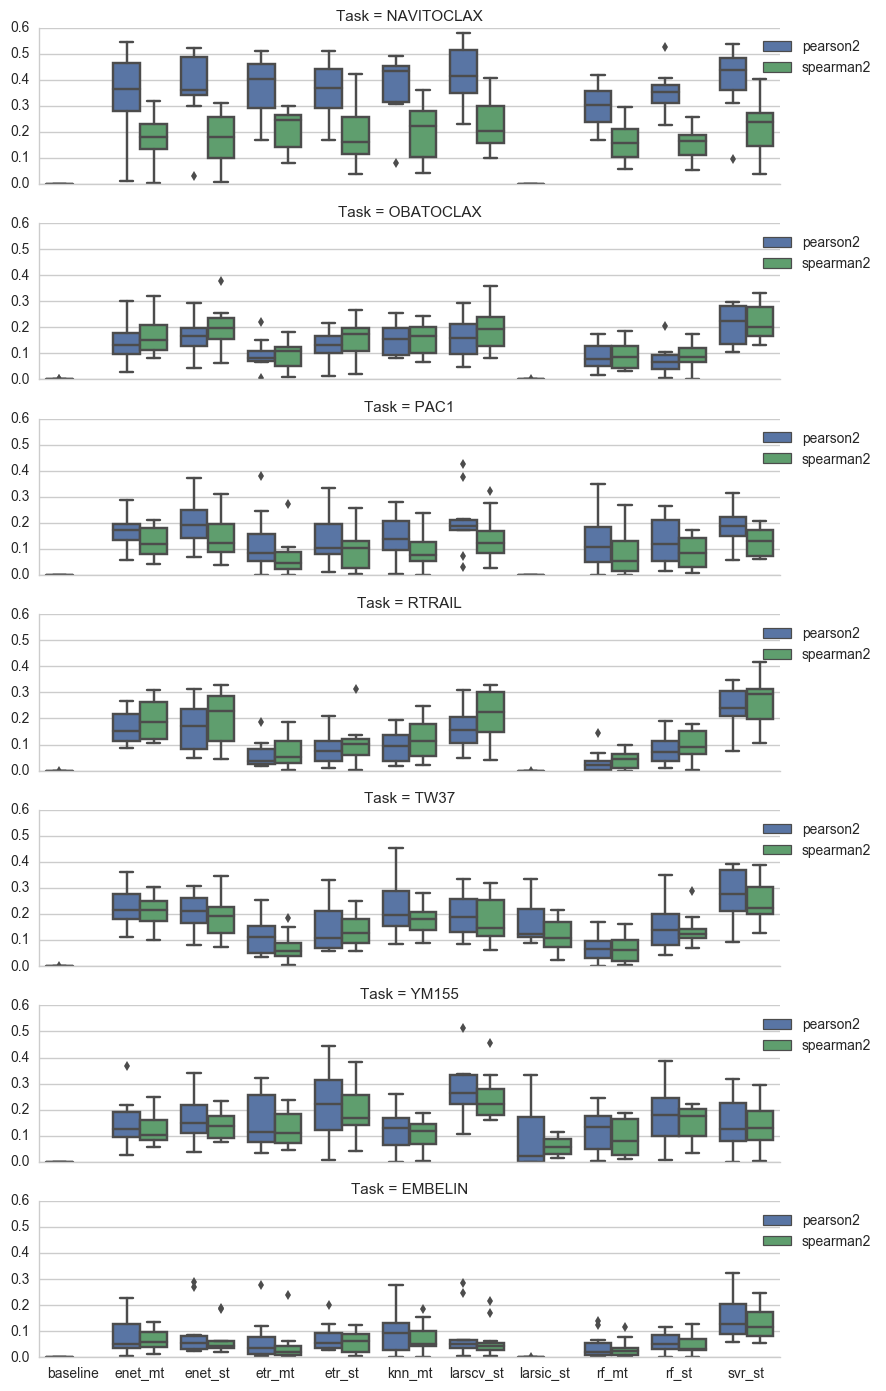

In [19]:
#tasks = performance.sample_tasks(d_score, random_state=None, limit=10)
# d_score_norm
grid, d_viz = performance.visualize(
    d_score, metrics=['pearson', 'spearman']
    #figaspect=4, legend_margin=(1.14, 1)
)
print(experiment_name)

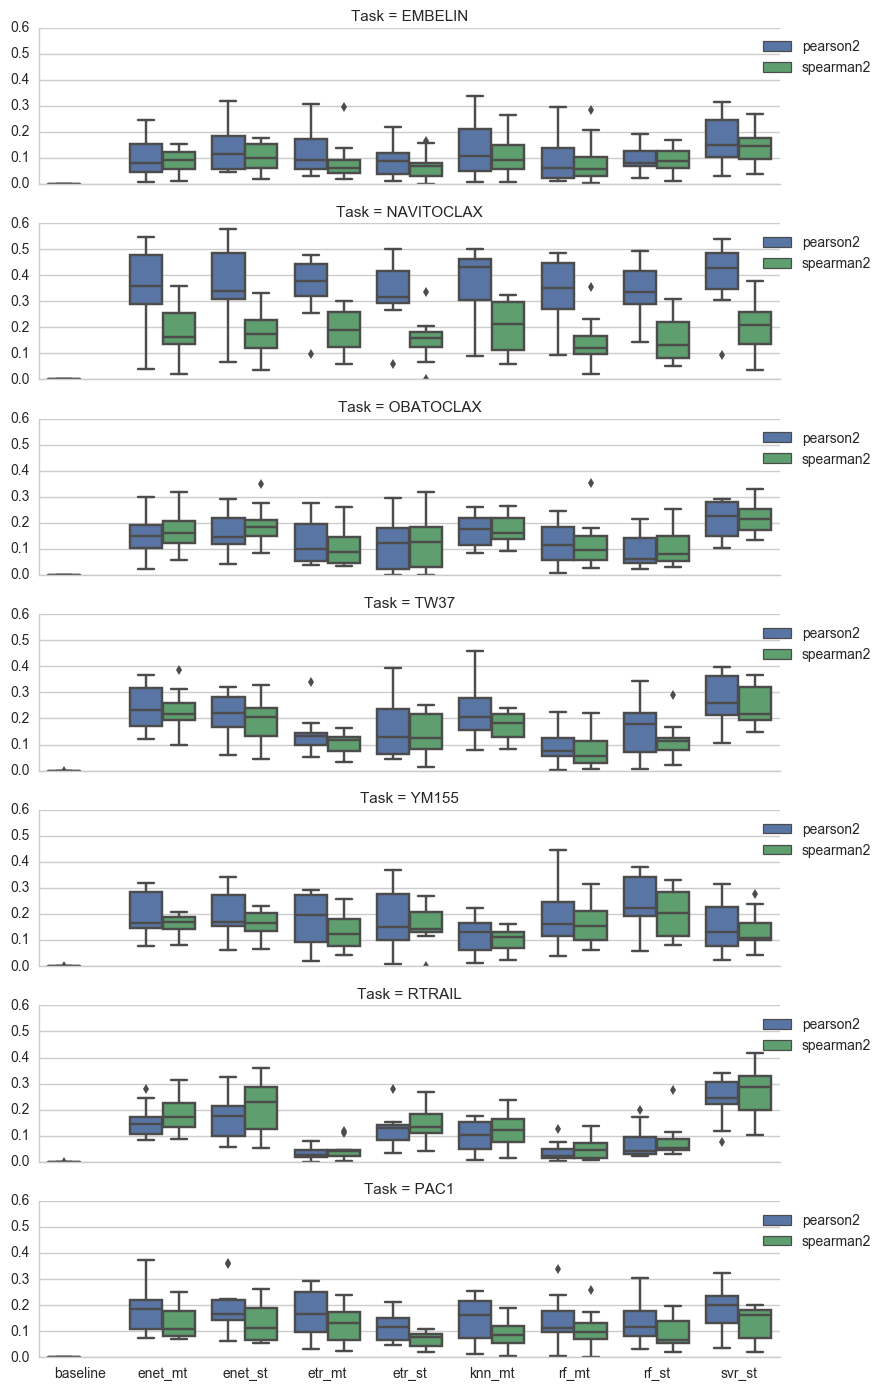

In [184]:
#tasks = performance.sample_tasks(d_score, random_state=None, limit=10)
grid, d_viz = performance.plot_scores(
    d_score, metrics=['pearson2', 'spearman2'],
    figaspect=4, legend_margin=(1.14, 1)
)

# Aggregate Results

In [20]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [408]:
from ml.api.results import performance, predictions
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

experiments = rx_train.get_training_result_versions('single_source/current')
d_score = []


score_fns = {
    'mse': lambda yt, yp: -mean_squared_error(yt, yp),
    'mae': lambda yt, yp: -mean_absolute_error(yt, yp),
    'mde': lambda yt, yp: -median_absolute_error(yt, yp),
    'r2': lambda yt, yp: r2_score(yt, yp), 
    'pearson': lambda yt, yp: yt.corr(yp, method='pearson'),
    'spearman': lambda yt, yp: yt.corr(yp, method='spearman'),
    'n': lambda yt, yp: len(yt)
}
    
def load_experiment_scores(experiment):
    train_res = rx_train.get_training_results('single_source/current', experiment)
    if train_res.mode == 'regression':
        train_res.mode = 'regressor'
    
    d_pred = predictions.extract(train_res)
    def score_fn(y_true, y_pred):
        mask = y_true.notnull()
        y_true = y_true[mask.values]
        y_pred = y_pred[mask.values]
        if len(y_pred) == 0:
            return {k:np.nan for k in score_fns}
        else:
            return {k:score_fns[k](y_true, y_pred) for k in score_fns}
    return (
        performance
        .extract(train_res, d_pred, score_fn)
        .assign(Experiment=experiment)
    )
    
for experiment in experiments:
    try:
        d_score.append(load_experiment_scores(experiment))
    except InterruptedError:
        raise
    except:
        logger.error('Failed to load experiment "{}"'.format(experiment))
    

d_score = pd.concat(d_score)

2017-02-17 11:16:04,733:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp1/results.pkl"
2017-02-17 11:16:04,733:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp1/results.pkl"
2017-02-17 11:17:49,265:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp4/results.pkl"
2017-02-17 11:17:49,265:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/current/exp4/results.pkl"
2017-02-17 11:19:33,440:DEBUG:py_utils.io_utils: Restoring serialized object "Training Results" from location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/curren

In [409]:
d_score.head()

Metric        Experiment       mae                                            \
Task                         AICAR     BX912   GDC0449 GSK1070916 NAVITOCLAX   
Model    Fold                                                                  
baseline 1          exp1 -1.049185 -1.652767 -0.788456  -1.657924  -1.412668   
         2          exp1 -1.021315 -1.264429 -0.715695  -1.663181  -1.398098   
         3          exp1 -1.048912 -1.651599 -0.685824  -1.771813  -1.531690   
         4          exp1 -0.992892 -1.376812 -0.648758  -1.445373  -1.475512   
         5          exp1 -1.183053 -1.454069 -0.814104  -1.449108  -1.341706   

Metric                                                            ...          \
Task          NILOTINIB NPK76II721 TUBASTATINA VORINOSTAT         ...           
Model    Fold                                                     ...           
baseline 1    -1.045221  -1.437970   -1.055654  -0.994269         ...           
         2    -1.073348  -1.306302   -1.057865  -1.129655         ...           
         3    -1.017592  -1.451685   -1.125751  -0.891667         ...           
         4    -0.909674  -1.322097   -1.038683  -0.799626         ...           
         5    -0.842633  -1.331981   -1.118567  -0.847683         ...           

Metric          spearman                                           \
Task          VORINOSTAT VX702 ctd_v2:NAVITOCLAX ctd_v2:NILOTINIB   
Model    Fold                                                       
baseline 1           NaN   NaN               NaN              NaN   
         2           NaN   NaN               NaN              NaN   
         3           NaN   NaN               NaN              NaN   
         4           NaN   NaN               NaN              NaN   
         5           NaN   NaN               NaN              NaN   

Metric                                                                \
Task          ctd_v2:VORINOSTAT gdsc_v2:NAVITOCLAX gdsc_v2:NILOTINIB   
Model    Fold                                                          
baseline 1                  NaN                NaN               NaN   
         2                  NaN                NaN               NaN   
         3                  NaN                NaN               NaN   
         4                  NaN                NaN               NaN   
         5                  NaN                NaN               NaN   

Metric                                                                   
Task          gdsc_v2:VORINOSTAT nci60_v2:NILOTINIB nci60_v2:VORINOSTAT  
Model    Fold                                                            
baseline 1                   NaN                NaN                 NaN  
         2                   NaN                NaN                 NaN  
         3                   NaN                NaN                 NaN  
         4                   NaN                NaN                 NaN  
         5                   NaN                NaN                 NaN  

[5 rows x 127 columns]

In [410]:
d_score.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 700 entries, (baseline, 1) to (svr_st, 10)
Columns: 127 entries, (Experiment, ) to (spearman, nci60_v2:VORINOSTAT)
dtypes: float64(126), object(1)
memory usage: 696.2+ KB


In [411]:
d_score.head()

Metric        Experiment       mae                                            \
Task                         AICAR     BX912   GDC0449 GSK1070916 NAVITOCLAX   
Model    Fold                                                                  
baseline 1          exp1 -1.049185 -1.652767 -0.788456  -1.657924  -1.412668   
         2          exp1 -1.021315 -1.264429 -0.715695  -1.663181  -1.398098   
         3          exp1 -1.048912 -1.651599 -0.685824  -1.771813  -1.531690   
         4          exp1 -0.992892 -1.376812 -0.648758  -1.445373  -1.475512   
         5          exp1 -1.183053 -1.454069 -0.814104  -1.449108  -1.341706   

Metric                                                            ...          \
Task          NILOTINIB NPK76II721 TUBASTATINA VORINOSTAT         ...           
Model    Fold                                                     ...           
baseline 1    -1.045221  -1.437970   -1.055654  -0.994269         ...           
         2    -1.073348  -1.306302   -1.057865  -1.129655         ...           
         3    -1.017592  -1.451685   -1.125751  -0.891667         ...           
         4    -0.909674  -1.322097   -1.038683  -0.799626         ...           
         5    -0.842633  -1.331981   -1.118567  -0.847683         ...           

Metric          spearman                                           \
Task          VORINOSTAT VX702 ctd_v2:NAVITOCLAX ctd_v2:NILOTINIB   
Model    Fold                                                       
baseline 1           NaN   NaN               NaN              NaN   
         2           NaN   NaN               NaN              NaN   
         3           NaN   NaN               NaN              NaN   
         4           NaN   NaN               NaN              NaN   
         5           NaN   NaN               NaN              NaN   

Metric                                                                \
Task          ctd_v2:VORINOSTAT gdsc_v2:NAVITOCLAX gdsc_v2:NILOTINIB   
Model    Fold                                                          
baseline 1                  NaN                NaN               NaN   
         2                  NaN                NaN               NaN   
         3                  NaN                NaN               NaN   
         4                  NaN                NaN               NaN   
         5                  NaN                NaN               NaN   

Metric                                                                   
Task          gdsc_v2:VORINOSTAT nci60_v2:NILOTINIB nci60_v2:VORINOSTAT  
Model    Fold                                                            
baseline 1                   NaN                NaN                 NaN  
         2                   NaN                NaN                 NaN  
         3                   NaN                NaN                 NaN  
         4                   NaN                NaN                 NaN  
         5                   NaN                NaN                 NaN  

[5 rows x 127 columns]

In [412]:
dt = d_score.set_index('Experiment', append=True).stack().stack().rename('Value').reset_index()
dt = dt.groupby(['Experiment', 'Model', 'Task', 'Metric'])['Value'].mean().reset_index()

dt['Type'] = dt['Model'].apply(lambda v: 'Single' if '_st' in v else ('Multi' if '_mt' in v else None))
dt['ModelFam'] = dt['Model'].str.split('_').str[0]

dt['Task'] = dt['Task'].apply(lambda v: v.replace('gdsc_v2:', '') if v.startswith('gdsc_v2:') else v)

scale = lambda v: (v - v.mean()) / v.std()
def normalize(g):
    g['NormValue'] = scale(g['Value'])
    return g
dt = dt.groupby(['Task', 'Metric'], group_keys=False).apply(normalize)

dt.head()

Experiment     Model   Task   Metric         Value  Type  ModelFam  \
0       exp1  baseline  AICAR      mae -1.016042e+00  None  baseline   
1       exp1  baseline  AICAR      mde -7.756061e-01  None  baseline   
2       exp1  baseline  AICAR      mse -1.703867e+00  None  baseline   
3       exp1  baseline  AICAR        n  5.340000e+01  None  baseline   
4       exp1  baseline  AICAR  pearson -1.361170e-16  None  baseline   

   NormValue  
0  -1.515425  
1  -1.002359  
2  -1.497637  
3        NaN  
4  -2.660126

In [424]:
def plot_models_by_task(d, metrics=None, value='NormValue'):
    
    if metrics is not None:
        d = d[d['Metric'].isin(metrics)]
        
    d = d.groupby(['Task', 'Experiment', 'Model'])[value].mean().reset_index()
    
    for k1, g1 in d.groupby(['Task']):
        g2 = g1.pivot(index='Experiment', columns='Model', values=value)
        g2 = g2.loc[g2.max(axis=1).sort_values().index]
        layout = dict(title=k1, hovermode='closest')
        fig = g2.iplot(mode='markers', asFigure=True, layout=layout)
        plty.offline.iplt(fig)

#plot_models_by_task(dt)
plot_models_by_task(dt, metrics=['mse'], value='Value')

In [415]:
dt.head()

Experiment     Model   Task   Metric         Value  Type  ModelFam  \
0       exp1  baseline  AICAR      mae -1.016042e+00  None  baseline   
1       exp1  baseline  AICAR      mde -7.756061e-01  None  baseline   
2       exp1  baseline  AICAR      mse -1.703867e+00  None  baseline   
3       exp1  baseline  AICAR        n  5.340000e+01  None  baseline   
4       exp1  baseline  AICAR  pearson -1.361170e-16  None  baseline   

   NormValue  
0  -1.515425  
1  -1.002359  
2  -1.497637  
3        NaN  
4  -2.660126

In [416]:
dt['Model'].value_counts()

enet_st        406
etr_st         406
etr_mt         406
svr_st         406
lasso_mt       406
enet_mt        406
larscv_st      406
lasso_st       405
larsic_st      400
rf_st          350
rf_mt          350
baseline       300
baseline_mt     47
Name: Model, dtype: int64

In [418]:
from py_utils.pandas_utils import one_value

def plot_model_type_by_task(d, metrics=None, models=None):
    
    if metrics is not None:
        d = d[d['Metric'].isin(metrics)]
        
    if models is not None:
        d = d[d['ModelFam'].isin(models)]
        
    # Aggregate across metrics
    d = d.groupby(['Task', 'Experiment', 'Type']).apply(lambda g: g.sort_values('Value', ascending=False).head(1))
    
    for k1, g1 in d.groupby(['Task']):
        g2 = g1.pivot_table(index=['Experiment', 'Type'], columns='Model', values='Value', aggfunc=one_value)
        g2 = g2.loc[g2.mean(axis=1).sort_values().index]
        layout = dict(title=k1, hovermode='closest')
        fig = g2.iplot(mode='markers', asFigure=True, layout=layout)
        plty.offline.iplt(fig)

#plot_by_task(dt)
#plot_model_type_by_task(dt, metrics=['spearman'], models=['enet', 'rf', 'etr'])
plot_model_type_by_task(dt, metrics=['r2'], models=['enet', 'rf', 'etr'])